In [1]:
# Under Construction

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import os
from galaxy2galaxy import problems
from skimage.measure import label
import tensorflow as tf
import starlet

tf.enable_eager_execution()


%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['targets'] /= 4000
    dico['inputs'] /= 4000

    return dico['inputs'], dico['targets'], dico['psf_cfht']/dico['psf_hst']

In [4]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, tf.complex64)


def fft(data):

    return ( tf.convert_to_tensor(1.0/data.get_shape().as_list()[0], tf.complex64) * 
             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) )


def ifft(data):

    return ( tf.convert_to_tensor(data.get_shape().as_list()[0], tf.complex64) *
             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) )


def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)


def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(psf)
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H + rho*sigma**2)
    return tf.cast(tf.math.reduce_max(normH), tf.complex64)


def blob_mask(img,background=0,connectivity=2):
    
    """This function keeps the biggest blob in the image
    
    INPUT: img, Numpy Array
           background, integer
           connectivity, integer
    OUTPUT: mask, boolean Numpy Array"""
    
    labels = label(img,background=background,connectivity=connectivity)
    
    # find the biggest blob
    indices = np.unique(labels)
    sizes = np.zeros(indices.shape)
    for i in indices[1:]:
        sizes[i] = (labels==i).sum()
    main_blob_label = np.argmax(sizes)
    main_blob_estimate = (labels==main_blob_label)*main_blob_label
    
    # extract mask
    mask = (labels-main_blob_estimate)==0
    return mask

### Loading Galaxy Images

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the hsc_problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/attrs2img_cosmos_cfht2hst')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


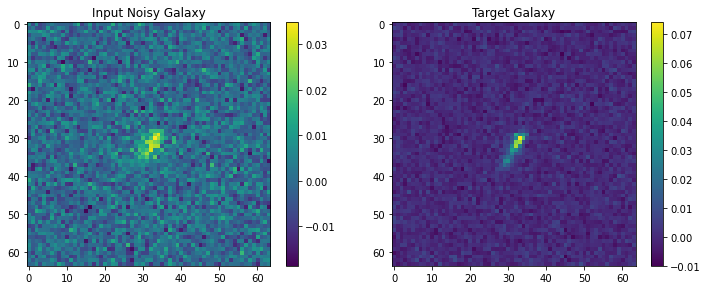

0.0059869206


In [6]:
ind_val = 7  # Corresponding ground truth & PSF in a batch

gal_input = np.squeeze(batch[0][ind_val])
gal_target = np.squeeze(batch[1][ind_val])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(gal_input)
plt.title("Input Noisy Galaxy")
plt.colorbar(shrink=0.375)

plt.subplot(122)
plt.imshow(gal_target)
plt.title("Target Galaxy")
plt.colorbar(shrink=0.375)

plt.show()

sigma_est = np.std(gal_input[0:20, 0:20])
print(sigma_est)

### Loading PSF

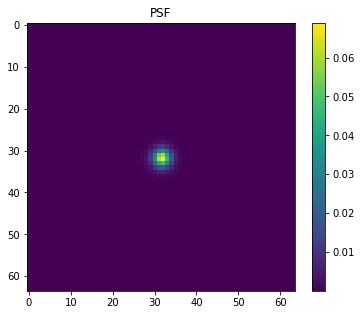

1.0


In [7]:
psf = cv.resize(np.real(np.fft.ifftshift(np.fft.irfft2(np.squeeze(batch[2][ind_val])))), (64,64), interpolation = cv.INTER_AREA)
psf /= np.sum(psf)

plt.figure(figsize=(6,6))
plt.imshow(psf)
plt.title('PSF')
plt.colorbar(shrink=0.82)
plt.show()

print(np.sum(psf))

### Load Trained U-Net Model

In [8]:
model = tf.keras.models.load_model('UNet_Denoiser/Models/UNet_small', compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Forward-Backward Algorithm

#### The loss function

$ L(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2 \\\\\\ 
\nabla L(x) = \frac{1}{\sigma^2} H^T(Hx - y)  \\\\\\
\nabla L(x_{true}) = \frac{1}{\sigma^2} H^Tn; \hspace{0.75cm} since \hspace{0.5cm} y = Hx_{true} + n\hspace{0.75cm} s.t. \hspace{0.5cm} n \hspace{0.25cm} WAGN \\\\\\ $

#### Compute Variance of -

$ \hspace{0.75cm} \alpha\nabla L(x_{true}) = \frac{\alpha}{\sigma^2} H^Tn \\\\\\ 
\hspace{0.75cm} \text {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^4} \text {Cov[}(H^Tn)] = \frac{\alpha^2}{\sigma^4} \sigma^2 H^T H;  \hspace{0.75cm} \text{as  Cov(} H^Tn) = H^T \text{Cov(} n) (H^T)^T \\\\\\
\Rightarrow \hspace{0.25cm} {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^2} H^TH \\\\\\ $

#### Now, 

$\hspace{0.8cm} AA^T [i,i] = \sum_j A[i,j]A^T[j,i] = \sum_j A^2[i,j] = \lVert A \rVert_F^2 \\\\\\ 
\therefore \hspace{0.25cm} \text {Cov(} \alpha \nabla L(x_{true}))[i,i] = \frac{\alpha^2}{\sigma^2} \lVert H \rVert_F^2 \\\\\\ 
\Rightarrow \hspace{0.25cm} \sigma_{grad} = \alpha \lVert H \rVert_F \sigma_{U-Net}\\\\\\ $


#### After plugging U-Net

$ L(x) = L_d + p(x), \hspace{0.75cm} where \hspace{0.5cm} L_d(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2\\\\\\ $

##### Forward backward Splitting
While not converged:
$ \hspace{0.5cm} X^{(k+\frac{1}{2})} \leftarrow X^{(k)} - \alpha \nabla L_d(X^{(k)}) $
$\\\\\\ \hspace{4.1cm} X^{(k+1)} \leftarrow X^{(k)} - prox_\alpha X^{(k+\frac{1}{2})} \\\\\\ $
$ \hspace{6cm} =  \alpha \lVert H \rVert_F . UNet (\frac{X^{(k+\frac{1}{2})}}{\alpha\lVert H \rVert_F}) $

Note that: 
$ \hspace{0.5cm} Var (\frac{\sigma_0}{\sigma}n) = \frac{\sigma_0^2}{\sigma^2} Var(n) = \sigma_0^2$

##### Empirically estimate standard deviation of $\alpha \nabla L_d(x_{true})$ : $\hspace{0.5cm} \alpha H^T  n$
$ \hspace{0.5cm}x^{(0)} = 0 $
$ \\\\\\ \hspace{0.5cm}x^{(\frac{1}{2})} = x^{(0)} - \alpha \nabla L_d(x_{true}) $
$ \hspace{0.5cm}x^{(\frac{1}{2})} = \alpha H^T n $
$ \\\\\\ \hspace{0.5cm}Hx_{true} - y = n $

##### Check if:

$ \\\\\\ \hspace{0.5cm}np.std(x^{(\frac{1}{2})}) = np.std(\alpha H^T n) \hspace{1.0cm} (Empirical \hspace{0.175cm} value) \\\\\\ \hspace{2.75cm} = \alpha \lVert H \rVert_F \sigma \hspace{2.05cm} (Theoretical \hspace{0.175cm} value) $


In [9]:
gal_input_tf = tf.cast(gal_input, tf.complex64)
psf_tf = tf.cast(psf, tf.complex64) 

gal_target_tf = tf.cast(gal_target, tf.complex64)
gal_target_nmse = tf.cast((gal_target > 2*(sigma_noise/4000)) * gal_target, tf.complex64)

In [10]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(tf.math.real(xi), 0.0), tf.complex64)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    cost_val = (tf.cast(0.5, tf.complex64) / var) * tf.norm(y - H(ifft(x_rec), psf))**2 
    return tf.keras.backend.eval(tf.math.real(cost_val))


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(psf)
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]))
    return tf.cast(tf.math.reduce_max(normH), tf.complex64)
    
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.complex64) / 
            (sv * tf.cast(1.0 + 1.0e-5, tf.complex64)))


def runFB(y, x_0, psf, grad, disp_step, n_iter, denoise):
    

    # Convert arrays to tensors      
    x_0 = tf.cast(x_0, tf.complex64)
    x_k = x_0

    
    # declare variables   
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.complex64)
    count = 0
    
    sigma = tf.cast(sigma_noise, tf.complex64) / 4000.0
    
    sv = max_sv(psf)
    alpha = get_alpha(sv)
    
    
    for k in range(n_iter):
        
        ## Gradient Descent update
        
        x_k1 = x_k - alpha * grad(y, x_k, psf)   
        
        
        # Check sigma values
        
        if k==0:
            print('STD [σ]: ', tf.keras.backend.get_value(np.real(sigma)))
            print('STD [n]: ', np.std(tf.keras.backend.get_value(H(tf.cast(gal_target, tf.complex64), psf) - y)[0:20,0:20]))

            temp = np.real(tf.keras.backend.get_value(x_k1))
            temp2 = np.real(tf.keras.backend.get_value(alpha * Ht(H(tf.cast(gal_target, tf.complex64), psf) - y, psf)))

            print()
            print('Observed:', np.std(temp[0:20,0:20]))    
            print('Empirical:', np.std(temp2[0:20,0:20]))      
            print('Theoretical:', np.real(tf.keras.backend.get_value(alpha * tf.norm(psf, ord=2) * sigma)))

            fig = plt.subplots(1,2, figsize=(12,12))
            plt.subplot(121)
            plt.imshow(temp)
            plt.title(r'$x^{(1/2)}$ (Before Denoising)')
            plt.colorbar(shrink=0.375)
            plt.subplot(122)
            plt.imshow(temp2)
            plt.title(r'$\alpha . H^T n$ (Noise Map)')
            plt.colorbar(shrink=0.375)
            plt.show()

            
        # Starlet Denoising
        if denoise=='starlet':
            
            x_k1 = tf.cast(starlet.ST(np.real(tf.keras.backend.get_value(x_k1)), 
                                      np.real(tf.keras.backend.get_value(alpha)), 
                                      np.real(tf.keras.backend.get_value(sigma)),
                                      np.real(tf.keras.backend.get_value(psf))), tf.complex64)
           
        # U-Net Denoising
        elif denoise=='unet':
            
            x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
            x_k1 = tf.cast(tf.squeeze(model(tf.math.real(x_k1 / (alpha * tf.norm(psf, ord=2))))), tf.complex64) 
            x_k1 *= (alpha * tf.norm(psf, ord=2))

        
        ## Cost
        cost.append(cost_func(y, x_k1, psf, var=sigma**2))
           
    
        # Update variables
        x_k = x_k1
        
        
        # Reconstruction
        final_im = tf.math.real(x_k)
        final_im = tf.math.maximum(final_im, 0.0)      # project negative values
        
                
        # Compute NMSE
        
        nmse_arr[k] = nmse(tf.math.real(gal_target_nmse), final_im)
        
        
        # Check if optimal reconstruction is achieved
        if nmse_arr[k]==np.min(nmse_arr):
            x_opt = final_im

            
            
        # Display plots
        if (k+1)%disp_step==0:
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(k+1))
            ax1 = plt.gca()
            rec = tf.keras.backend.get_value(final_im)
            im1 = ax1.imshow(rec)
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Target')
            ax2 = plt.gca()
            im2 = ax2.imshow(gal_target)
            divider = make_axes_locatable(ax2)
            cax2 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im2, cax=cax2)

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(tf.keras.backend.get_value(final_im)[y.get_shape().as_list()[0]//2,:], label='rec_im')           
            ax3.plot(gal_target[y.get_shape().as_list()[0]//2,:], label='target')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())
            
            plt.show(fig)
                 
    return x_opt, cost, nmse_arr

STD [σ]:  0.0058975
STD [n]:  0.0060038506

Observed: 0.0011685881
Empirical: 0.001213676
Theoretical: 0.0010505358


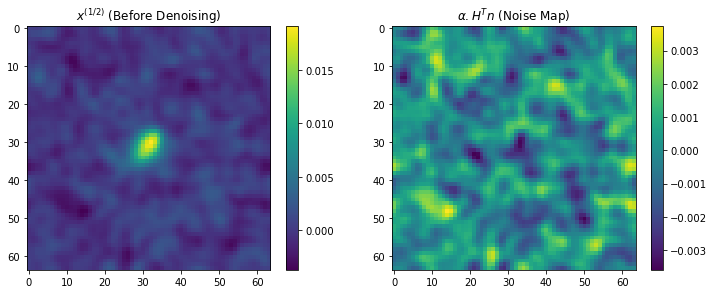

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


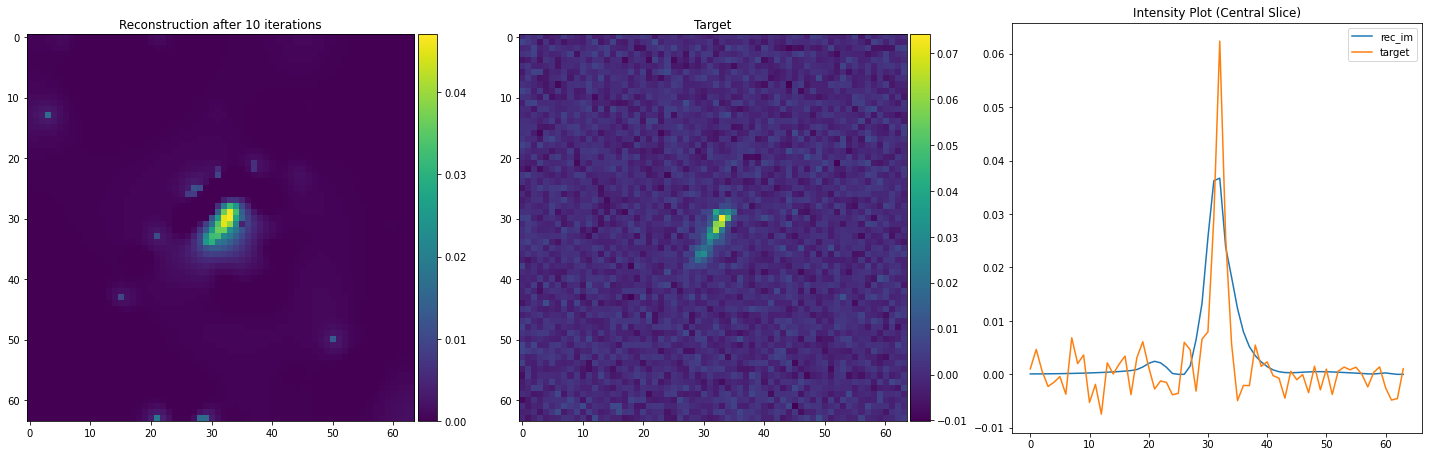

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


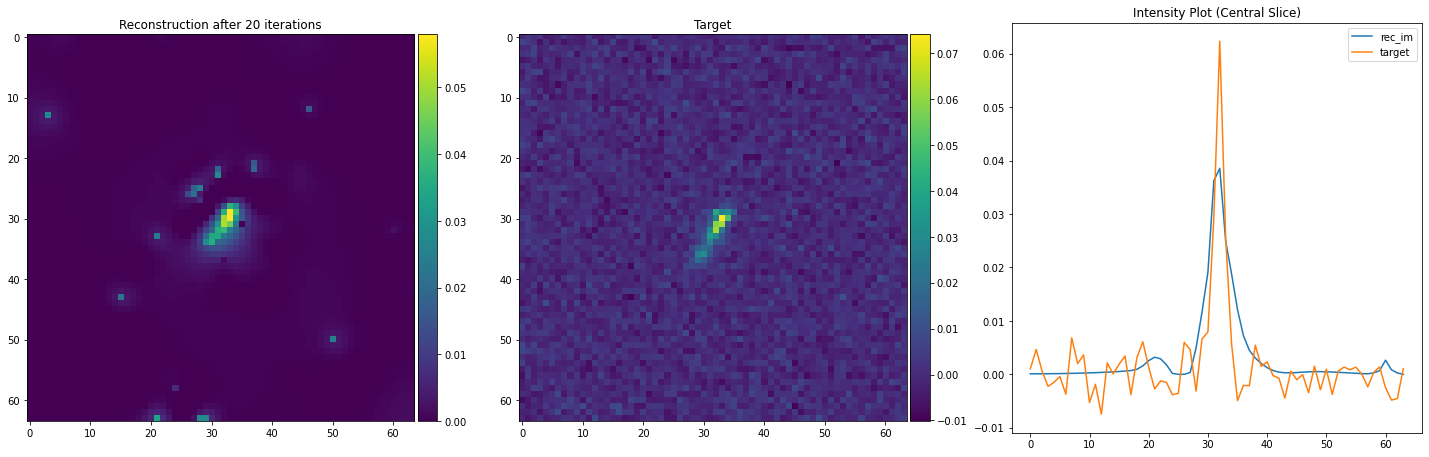

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


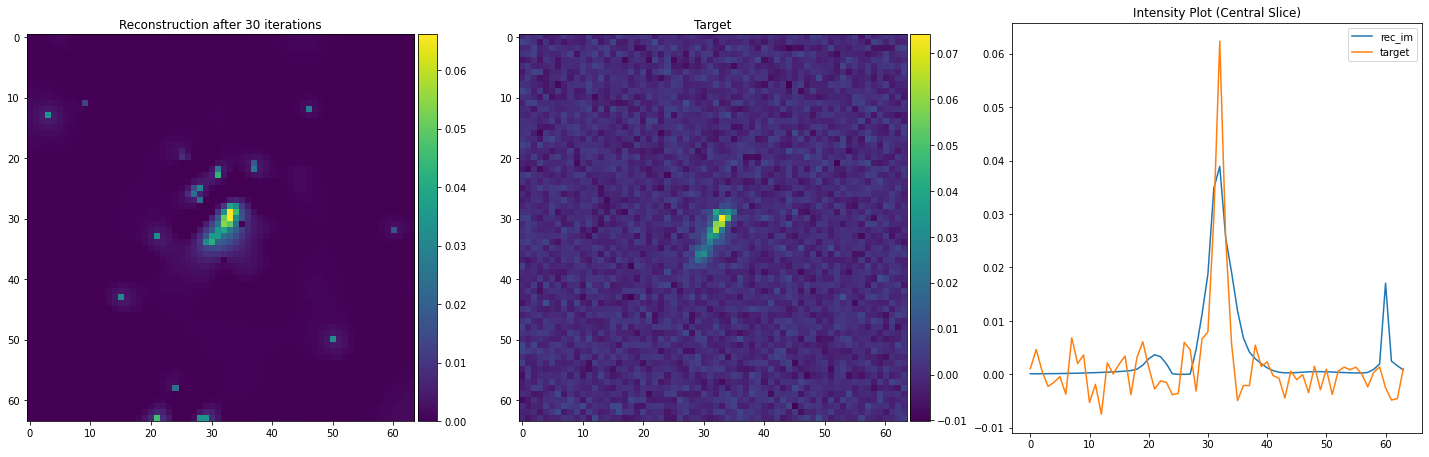

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


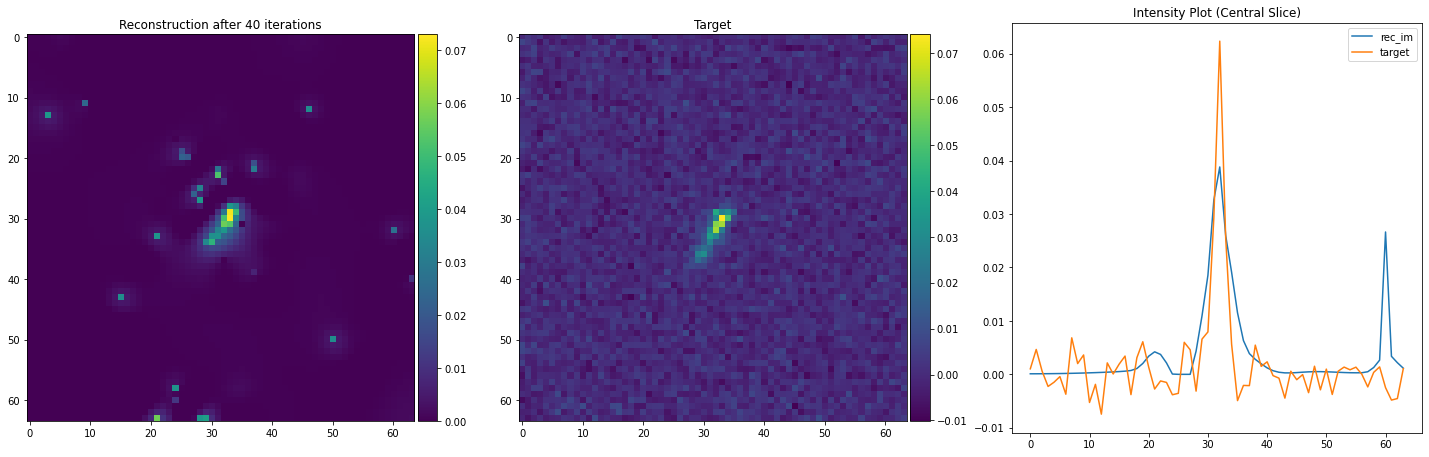

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


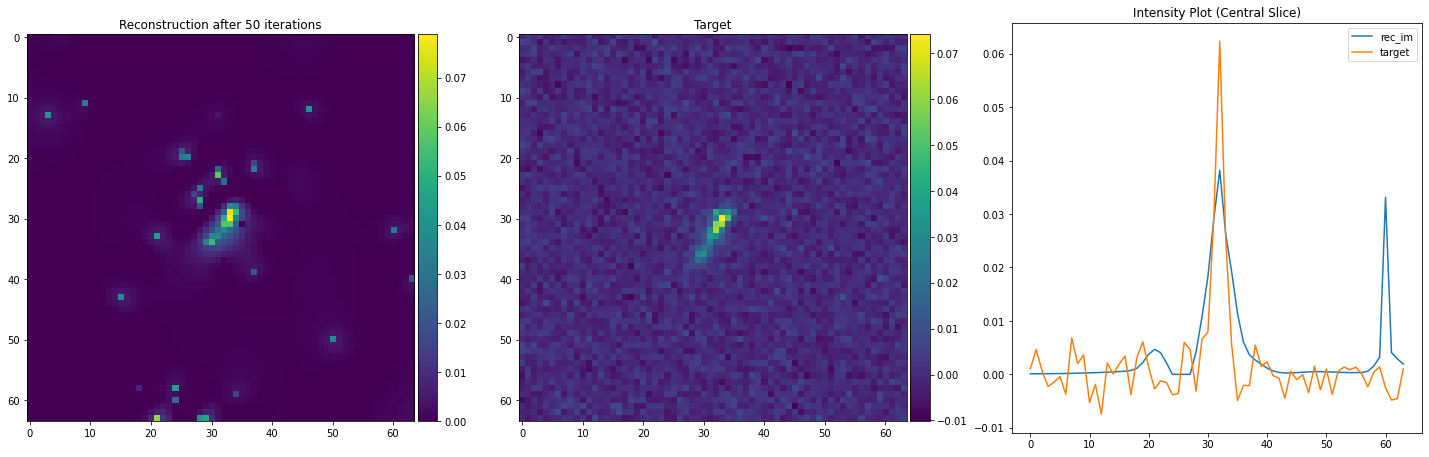

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


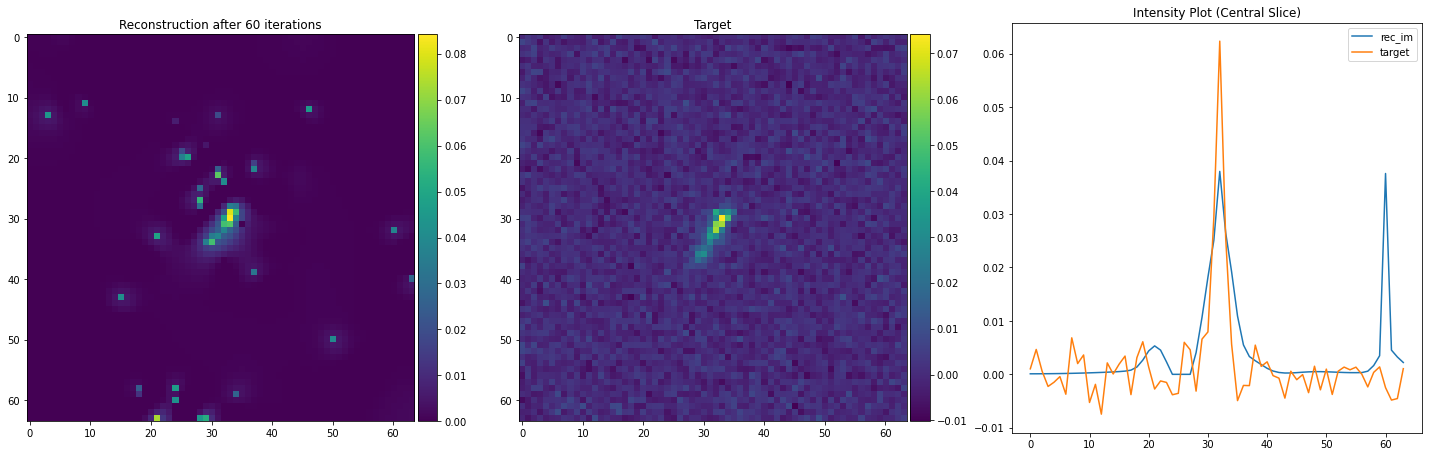

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


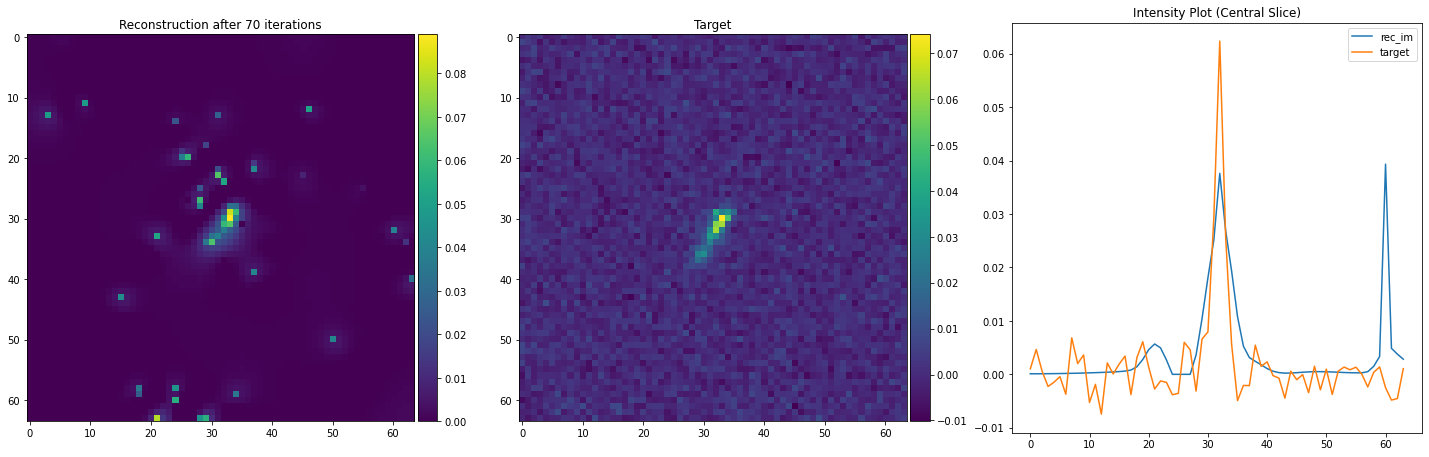

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


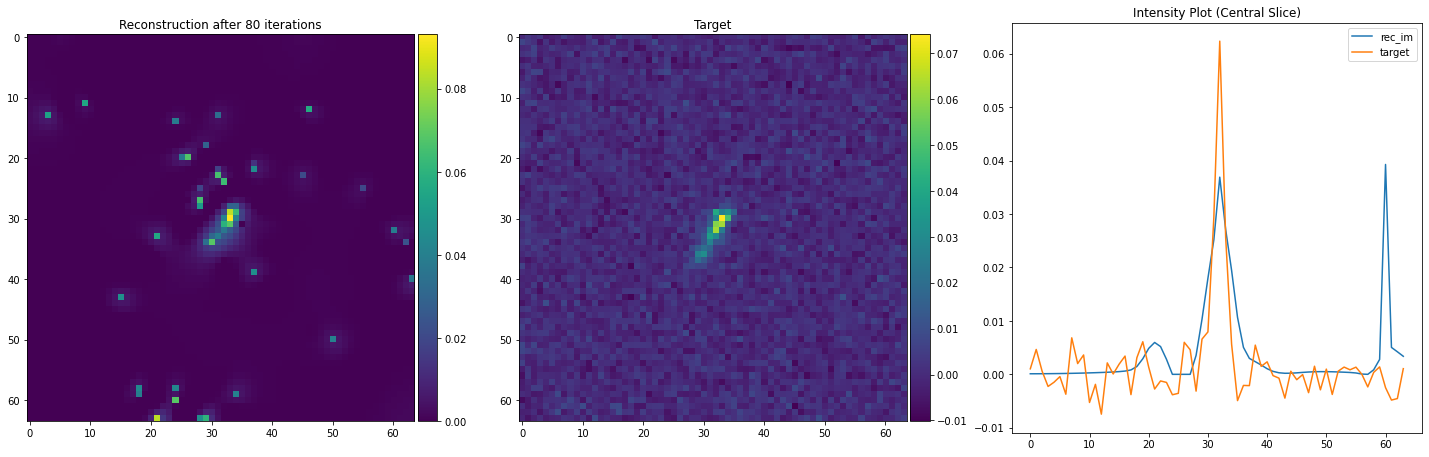

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


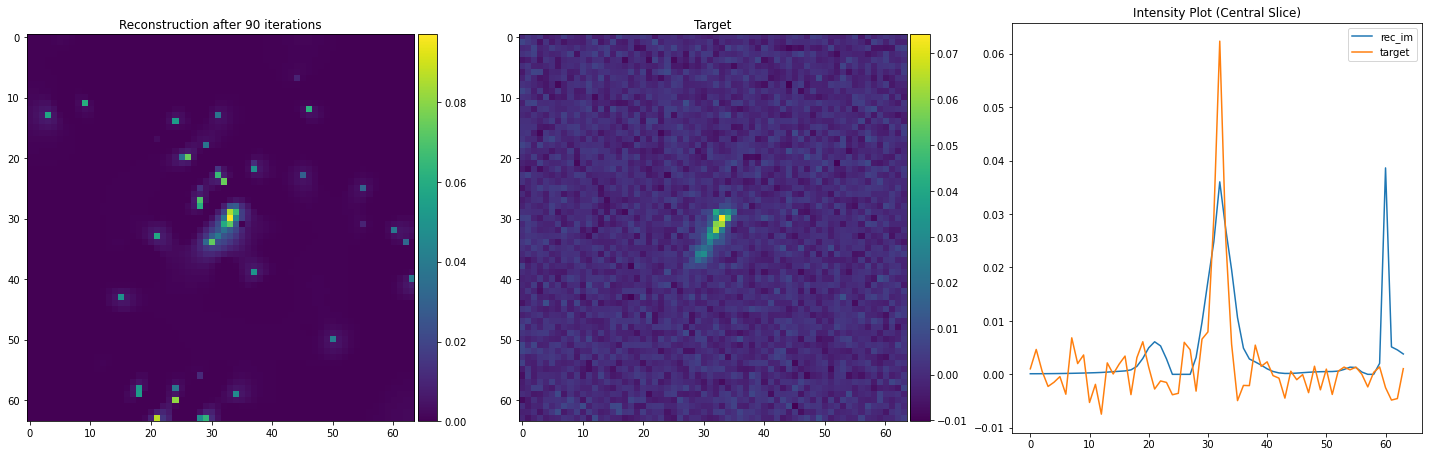

/local/home/ua264756/GitHub/ADMM/starlet.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thresholds = np.array([(k+plus)*sigma_scales[:1], k*sigma_scales[1:]])


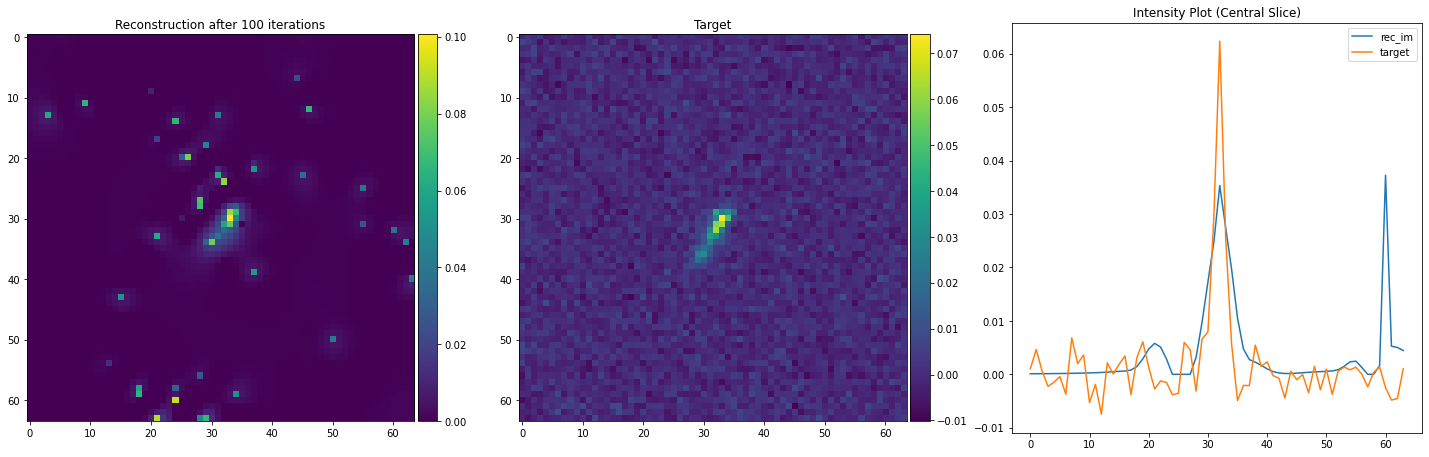

In [11]:
n_iter = 100
disp_step = 10

x_0 = np.zeros(gal_input.shape)

# Deconvolve the image
x_opt, cost, nmse_arr = runFB(gal_input_tf, x_0, psf_tf, grad, disp_step, n_iter, denoise='starlet')

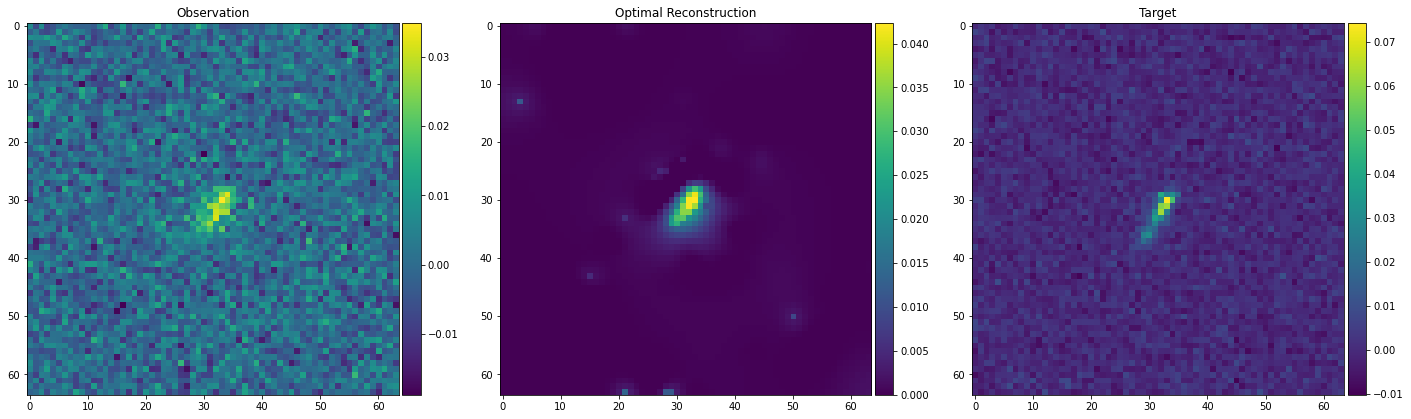

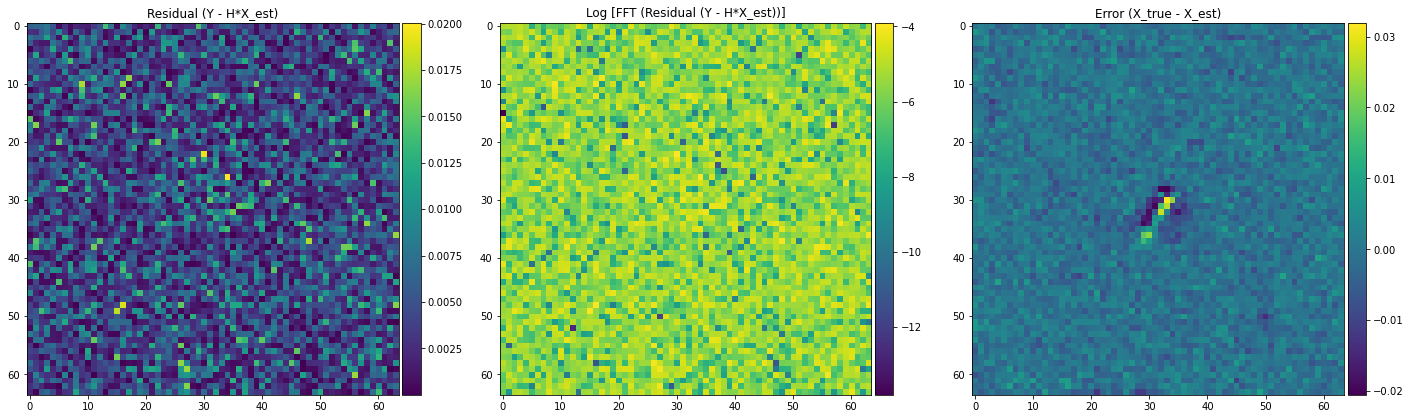

In [12]:
# Comparison

fig = plt.subplots(1,3, figsize=(24,24))

plt.subplot(131)
plt.title('Observation')
ax1 = plt.gca()
im1 = ax1.imshow(gal_input)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Optimal Reconstruction')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(tf.math.real(x_opt)))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Target')
ax3 = plt.gca()
im3 = ax3.imshow(gal_target)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig)


fig2 = plt.subplots(1,3, figsize=(24,24))
plt.subplot(131)
plt.title('Residual (Y - H*X_est)')
ax1 = plt.gca()
residual = tf.math.abs(gal_input_tf - fftconvolve(psf_tf, tf.cast(x_opt, tf.complex64)))
im1 = ax1.imshow(tf.keras.backend.get_value(residual))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Log [FFT (Residual (Y - H*X_est))]')
ax2 = plt.gca()
im2 = ax2.imshow(tf.keras.backend.get_value(tf.math.log(residual)))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Error (X_true - X_est)')
ax3 = plt.gca()
im3 = ax3.imshow(tf.keras.backend.get_value(tf.math.real(gal_target_tf) - x_opt))
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig2)

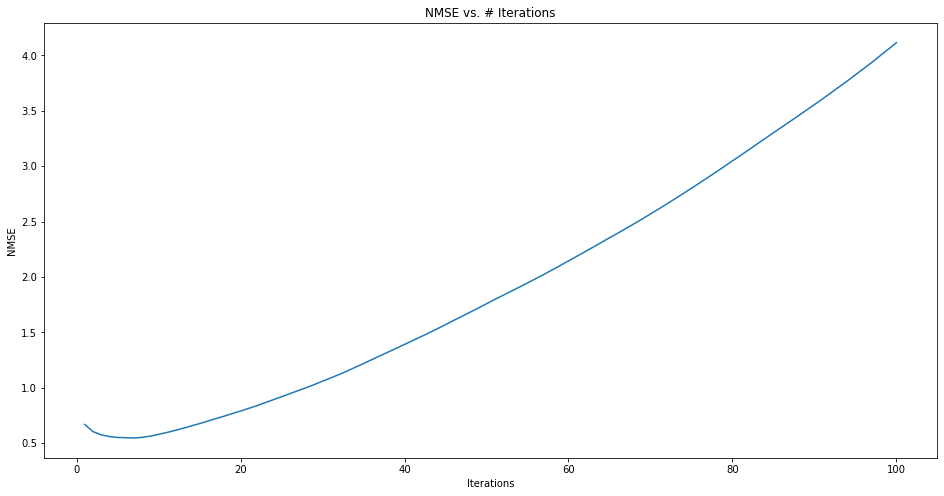


Minimum NMSE = 0.545365571975708 (at [7] iterations)


In [13]:
# Plot NMSE
min_nmse = np.min(nmse_arr)
min_iter_nmse = np.where(nmse_arr == min_nmse)[0] + 1

plt.figure(figsize=(16,8))
plt.plot(np.arange(1,n_iter+1), nmse_arr)
plt.title('NMSE vs. # Iterations')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show()
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter_nmse))

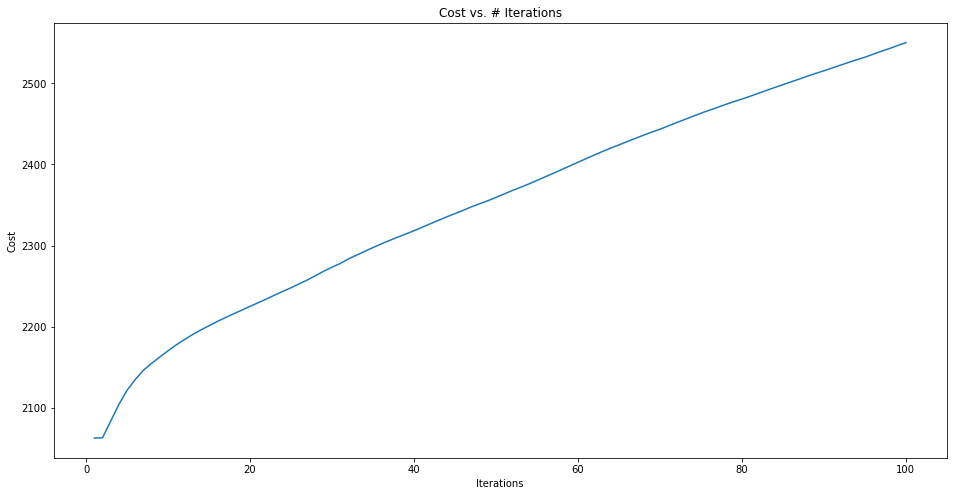


Minimum Cost = 2062.77978515625 (at [1] iterations)


In [14]:
# Plot cost
min_cost = np.min(cost)
min_iter_cost = np.where(cost == min_cost)[0] + 1

plt.figure(figsize=(16,8))
plt.plot(np.arange(1,n_iter+1), cost)
plt.title('Cost vs. # Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
print('\nMinimum Cost = {} (at {} iterations)'.format(min_cost, min_iter_cost))